In [1]:
# ======================================================
# 1. Mount Google Drive
# ======================================================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ======================================================
# 2. Imports
# ======================================================
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_fscore_support

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [3]:
# ======================================================
# 3. Config
# ======================================================
IMG_H, IMG_W = 155, 220
EMBED_DIM = 128
BATCH_SIZE = 16
EPOCHS = 20
MARGIN = 1.0

path_org = "/content/drive/MyDrive/CapstoneProject/signatures/full_org"
path_forg = "/content/drive/MyDrive/CapstoneProject/signatures/full_forg"

embedding_savedir = "/content/drive/MyDrive/SalinanCapstoneProject/embedding_saved_mobilenet"
os.makedirs(embedding_savedir, exist_ok=True)

In [4]:
# ======================================================
# 4. Load valid files
# ======================================================
valid_ext = (".png", ".jpg", ".jpeg", ".bmp")

org_files = [f for f in os.listdir(path_org) if f.lower().endswith(valid_ext)]
forg_files = [f for f in os.listdir(path_forg) if f.lower().endswith(valid_ext)]

def get_id(filename):
    parts = filename.split('_')
    try:
        return int(parts[1])
    except:
        return abs(hash(filename)) % 100000

org_dict, forg_dict = {}, {}
for f in org_files:
    org_dict.setdefault(get_id(f), []).append(f)
for f in forg_files:
    forg_dict.setdefault(get_id(f), []).append(f)

print("ORG writers:", len(org_dict))
print("FORG writers:", len(forg_dict))

ORG writers: 55
FORG writers: 55


In [5]:
# ======================================================
# 5. Preprocess + Light Augmentation
# ======================================================
def load_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("[WARNING] Cannot read:", path)
        return None

    try:
        img = cv2.resize(img, (IMG_W, IMG_H))
    except:
        print("[WARNING] Resize failed:", path)
        return None

    return img.astype("float32") / 255.0


def augment_light(img):
    out = img.copy()

    # small rotation
    if random.random() < 0.4:
        angle = random.uniform(-5, 5)
        M = cv2.getRotationMatrix2D((IMG_W//2, IMG_H//2), angle, 1.0)
        out = cv2.warpAffine((out*255).astype('uint8'), M, (IMG_W, IMG_H),
                             borderMode=cv2.BORDER_REPLICATE).astype("float32")/255.0

    # contrast shift
    if random.random() < 0.4:
        alpha = random.uniform(0.9, 1.1)
        beta = random.uniform(-0.05, 0.05)
        out = np.clip(out * alpha + beta, 0, 1)

    # slight blur
    if random.random() < 0.2:
        out = cv2.GaussianBlur((out*255).astype("uint8"), (3,3), 0).astype("float32")/255.0

    return out


def preprocess_aug(path):
    img = load_gray(path)
    if img is None: return None

    img = augment_light(img)

    img_rgb = np.stack([img, img, img], axis=-1)  # (H,W,3)

    img_rgb *= 255.0
    img_rgb = preprocess_input(img_rgb.astype("float32"))

    return img_rgb

In [7]:
# ======================================================
# 6. Build Pairs
# ======================================================
pairs = []
labels = []

def valid(x):
    return (x is not None) and (x.shape == (IMG_H, IMG_W, 3))

# positive pairs
for pid, imgs in org_dict.items():
    if len(imgs) < 2: continue
    for i in range(len(imgs)-1):
        a = preprocess_aug(os.path.join(path_org, imgs[i]))
        b = preprocess_aug(os.path.join(path_org, imgs[i+1]))
        if valid(a) and valid(b):
            pairs.append([a,b]); labels.append(1)

# negative forgery pairs
for pid, fimgs in forg_dict.items():
    if pid in org_dict:
        for f in fimgs:
            a = preprocess_aug(os.path.join(path_org, random.choice(org_dict[pid])))
            b = preprocess_aug(os.path.join(path_forg, f))
            if valid(a) and valid(b):
                pairs.append([a,b]); labels.append(0)

# cross-negative pairs
org_pids = list(org_dict.keys())
for pid in org_pids:
    if len(org_pids) <= 1: break
    other = random.choice([x for x in org_pids if x != pid])
    a = preprocess_aug(os.path.join(path_org, random.choice(org_dict[pid])))
    b = preprocess_aug(os.path.join(path_org, random.choice(org_dict[other])))
    if valid(a) and valid(b):
        pairs.append([a,b]); labels.append(0)

pairs = np.array(pairs, dtype="float32")
labels = np.array(labels)
print("Pairs shape:", pairs.shape)

Pairs shape: (2640, 2, 155, 220, 3)


In [8]:
# ======================================================
# 7. Train/Test Split
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    pairs, labels, test_size=0.2, random_state=42
)

train_img1 = np.array([x[0] for x in X_train])
train_img2 = np.array([x[1] for x in X_train])
test_img1  = np.array([x[0] for x in X_test])
test_img2  = np.array([x[1] for x in X_test])

In [9]:
# ======================================================
# 8. Custom Layers
# ======================================================
@tf.keras.utils.register_keras_serializable(package="Custom", name="L2Normalize")
class L2Normalize(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)

@tf.keras.utils.register_keras_serializable(package="Custom", name="EuclideanDistance")
class EuclideanDistance(tf.keras.layers.Layer):
    def call(self, inputs):
        x, y = inputs
        return tf.sqrt(tf.maximum(
            tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True), 1e-7
        ))

In [10]:
# ======================================================
# 9. Build MobileNetV2 Backbone (pretrained, freeze first)
# ======================================================
def build_base_network(input_shape=(IMG_H, IMG_W, 3)):
    inp = Input(shape=input_shape)

    base = MobileNetV2(
        input_shape=(IMG_H, IMG_W, 3),
        include_top=False,
        weights="imagenet"
    )

    for layer in base.layers:
        layer.trainable = False

    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(EMBED_DIM, activation=None)(x)
    x = L2Normalize()(x)

    return Model(inp, x, name="mobilenetv2_embedding")

embedding_model = build_base_network()
embedding_model.summary()

/tmp/ipython-input-2008578754.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 155, 220, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalize (L2Normalize)      │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,618,816 (9.99 MB)

 Trainable params: 360,832 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# ======================================================
# 10. Siamese Architecture + Loss
# ======================================================
def contrastive_loss(y_true, y_pred):
    return K.mean(
        y_true * K.square(y_pred) +
        (1 - y_true) * K.square(tf.maximum(MARGIN - y_pred, 0))
    )

input_a = Input((IMG_H, IMG_W, 3))
input_b = Input((IMG_H, IMG_W, 3))

processed_a = embedding_model(input_a)
processed_b = embedding_model(input_b)

distance = EuclideanDistance()([processed_a, processed_b])

siamese_net = Model([input_a, input_b], distance)
siamese_net.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                    loss=contrastive_loss)

In [12]:
# ======================================================
# 11. Callbacks
# ======================================================
checkpoint_path = os.path.join(embedding_savedir, "siamese_best.weights.h5")
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss', save_best_only=True,
                             save_weights_only=True)

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
# ======================================================
# 12. Train Phase 1 (Backbone frozen)
# ======================================================
history = siamese_net.fit(
    [train_img1, train_img2], y_train,
    validation_data=([test_img1, test_img2], y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint, es]
)

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - loss: 0.1874 - val_loss: 0.1473
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1410 - val_loss: 0.1221
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1141 - val_loss: 0.1084
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0962 - val_loss: 0.0979
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0808 - val_loss: 0.0910
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0743 - val_loss: 0.0858
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0639 - val_loss: 0.0830
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0588 - val_loss: 0.0771
Epoch 9/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0540 - val_loss: 0.0752
Epoch 10/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0463 - val_loss: 0.0713
Epoch 11/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0432 - val_loss: 0.0695
Epoch 12/20
132/132 ━━━━━━━━━━━━━━━━━━━━

In [14]:
# ======================================================
# 12b. Fine-Tuning Phase 2 (unfreeze last 30 layers)
# ======================================================
print("\n🔧 Fine-tuning MobileNetV2...")

base_model = embedding_model.layers[1]  # Mobilenet is 2nd layer
unfreeze_count = 30

for layer in base_model.layers[-unfreeze_count:]:
    layer.trainable = True

siamese_net.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=contrastive_loss
)

history_ft = siamese_net.fit(
    [train_img1, train_img2], y_train,
    validation_data=([test_img1, test_img2], y_test),
    batch_size=BATCH_SIZE,
    epochs=12,
    callbacks=[checkpoint, es]
)


🔧 Fine-tuning MobileNetV2...
Epoch 1/12
132/132 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - loss: 0.1796 - val_loss: 0.0610
Epoch 2/12
132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.1410 - val_loss: 0.0696
Epoch 3/12
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.1293 - val_loss: 0.0749
Epoch 4/12
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.1079 - val_loss: 0.0875
Epoch 5/12
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0875 - val_loss: 0.0984
Epoch 6/12
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0777 - val_loss: 0.0999


In [15]:
# ======================================================
# 13. Save embedding model
# ======================================================
embedding_model.save(
    os.path.join(embedding_savedir, "embedding_model_clean.keras"),
    include_optimizer=False
)
embedding_model.save_weights(
    os.path.join(embedding_savedir, "embedding_weights_clean.weights.h5")
)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
ROC AUC: 0.9904 | EER: 0.0505 | EER_threshold: -0.5237
Precision: 0.9447 | Recall: 0.9522 | F1: 0.9484
Confusion matrix:
 [[263  14]
 [ 12 239]]


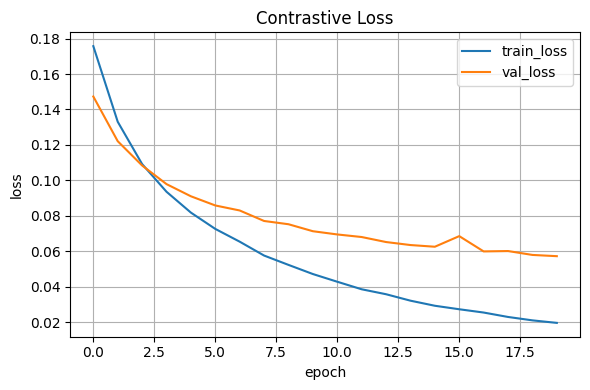

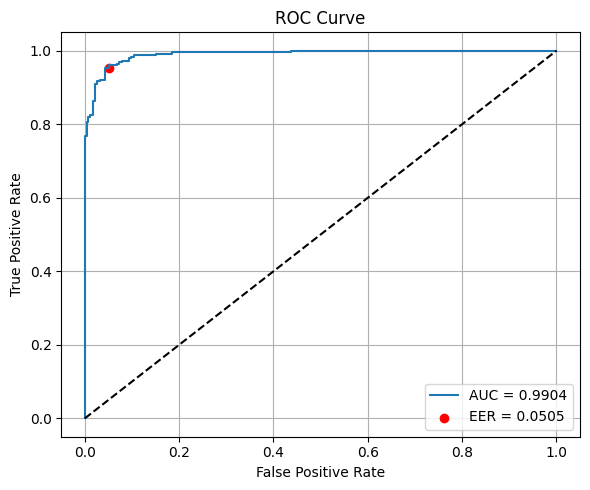

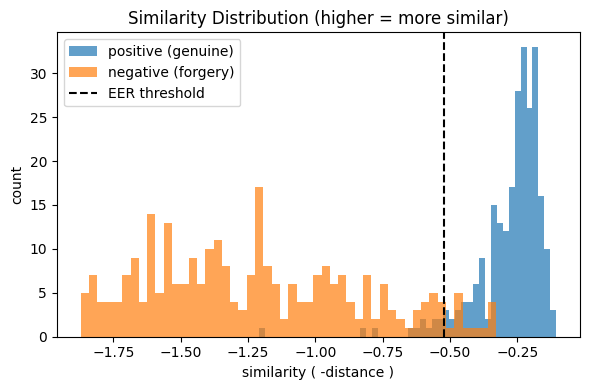

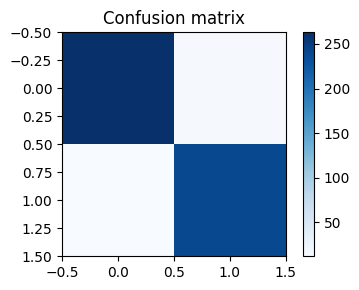

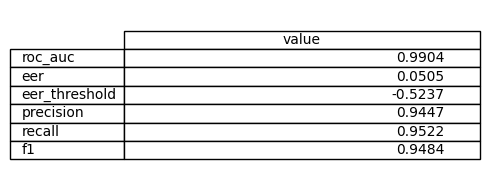

All artifacts saved to: /content/drive/MyDrive/SalinanCapstoneProject/embedding_saved_mobilenet


In [17]:
# ======================================================
# 14. Evaluate & compute metrics: ROC AUC & EER + other metrics
# ======================================================
# compute distances on test
y_pred_test = siamese_net.predict([test_img1, test_img2])[:, 0]

# For ROC: convert distance -> similarity (higher better)
sim_scores = -y_pred_test
auc_score = roc_auc_score(y_test, sim_scores)
fpr, tpr, thresholds = roc_curve(y_test, sim_scores)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.absolute(fnr - fpr))
eer_threshold = thresholds[eer_idx]
eer = fpr[eer_idx]

# Convert eer_threshold (on sim_scores) to a decision on similarity
decisions = (sim_scores >= eer_threshold).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, decisions, average='binary')

# confusion matrix
cm = confusion_matrix(y_test, decisions)

# save metrics
metrics = {
    "roc_auc": float(auc_score),
    "eer": float(eer),
    "eer_threshold": float(eer_threshold),
    "precision": float(precision),
    "recall": float(recall),
    "f1": float(f1)
}
np.savez(os.path.join(embedding_savedir, "metrics.npz"), **metrics)
pd.DataFrame([metrics]).to_csv(os.path.join(embedding_savedir, "metrics.csv"), index=False)

print(f"ROC AUC: {auc_score:.4f} | EER: {eer:.4f} | EER_threshold: {eer_threshold:.4f}")
print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
print("Confusion matrix:\n", cm)

# -------------------------
# Plotting: loss, ROC, distance histograms
# -------------------------
# 1) Training/Validation loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Contrastive Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(embedding_savedir, 'loss_curve.png'), dpi=150)
plt.show()

# 2) ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0,1],[0,1],'k--')
plt.scatter(fpr[eer_idx], tpr[eer_idx], c='red', label=f'EER = {eer:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(embedding_savedir, 'roc_curve.png'), dpi=150)
plt.show()

# 3) Histogram of similarity (pos vs neg)
sim_pos = sim_scores[y_test==1]
sim_neg = sim_scores[y_test==0]
plt.figure(figsize=(6,4))
plt.hist(sim_pos, bins=50, alpha=0.7, label='positive (genuine)')
plt.hist(sim_neg, bins=50, alpha=0.7, label='negative (forgery)')
plt.axvline(eer_threshold, color='k', linestyle='--', label='EER threshold')
plt.title('Similarity Distribution (higher = more similar)')
plt.xlabel('similarity ( -distance )')
plt.ylabel('count')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(embedding_savedir, 'similarity_hist.png'), dpi=150)
plt.show()

# 4) Save confusion matrix as CSV and as small figure
pd.DataFrame(cm, index=['neg','pos'], columns=['pred_neg','pred_pos']).to_csv(os.path.join(embedding_savedir, 'confusion_matrix.csv'))
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(embedding_savedir, 'confusion_matrix.png'), dpi=150)
plt.show()

# 5) Save a readable metrics table image (basic)
metrics_df = pd.DataFrame([metrics]).T
metrics_df.columns = ['value']
metrics_df.to_csv(os.path.join(embedding_savedir, 'metrics_table.csv'))
plt.figure(figsize=(5,2))
plt.axis('off')
tbl = plt.table(cellText=np.round(metrics_df.values,4), rowLabels=metrics_df.index, colLabels=metrics_df.columns, loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
plt.tight_layout()
plt.savefig(os.path.join(embedding_savedir, 'metrics_table.png'), dpi=150)
plt.show()

print("All artifacts saved to:", embedding_savedir)